In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import csv
import os
import pandas as pd
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [4]:
# --------------------------
# 1. Vocabulary Construction
# --------------------------
def build_vocab(corpus_path, vocab_size=50000):
    special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
    with open(corpus_path, 'r', encoding='utf-8') as f:
        text = f.read().split()
    token_counts = Counter(text)
    sorted_tokens = sorted(token_counts.items(), key=lambda x: (-x[1], x[0]))
    vocab = special_tokens.copy()
    vocab += [token for token, _ in sorted_tokens if token not in special_tokens][:vocab_size-len(special_tokens)]
    return {token: idx for idx, token in enumerate(vocab)}, vocab


In [5]:
# ----------------------
# 2. Model Architecture
# ----------------------
class BERT(nn.Module):
    def __init__(self, vocab_size, max_len=128, hidden_size=128, n_layers=2,n_heads=2,
                 intermediate_size=512, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.token_embed = nn.Embedding(vocab_size, hidden_size)
        self.pos_embed = nn.Embedding(max_len, hidden_size)
        self.layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=n_heads,
                dim_feedforward=intermediate_size,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            ),
            num_layers=n_layers
        )
        self.mlm_head = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, attention_mask):
        seq_len = input_ids.size(1)
        positions = torch.arange(seq_len, device=input_ids.device).expand(input_ids.size(0), seq_len)
        embeddings = self.token_embed(input_ids) + self.pos_embed(positions)
        output = self.layers(embeddings, src_key_padding_mask=(attention_mask==0))
        return self.mlm_head(output)

def create_aobertsmall(vocab_size):
    return BERT(vocab_size, hidden_size=128, n_layers=2, n_heads=2)
def create_aobertbase(vocab_size):
    return BERT(vocab_size, hidden_size=256, n_layers=4, n_heads=4)
def create_aobertlarge(vocab_size):
    return BERT(vocab_size, hidden_size=512, n_layers=6, n_heads=8)

In [6]:
# ---------------------------------
# 3. Prepare MLM Dataset
# ---------------------------------
class MLMDataset(Dataset):
    def __init__(self, corpus_path, token2id, max_len=128):
        self.token2id = token2id
        self.max_len = max_len
        self.data = []
        with open(corpus_path, 'r', encoding='utf-8') as f:
            for line in f:
                input_ids, attention_mask = self.tokenize(line.strip())
                self.data.append((input_ids, attention_mask))

    def tokenize(self, text):
        tokens = text.split()[:self.max_len-2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        input_ids = [self.token2id.get(t, self.token2id['[UNK]']) for t in tokens]
        pad_len = self.max_len - len(input_ids)
        input_ids_padded = input_ids + [self.token2id['[PAD]']]*pad_len
        attention_mask = [1]*len(input_ids) + [0]*pad_len
        return torch.tensor(input_ids_padded), torch.tensor(attention_mask)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, attention_mask = self.data[idx]
        labels = input_ids.clone()
        mask_prob = 0.15
        special_tokens = [
            self.token2id['[PAD]'],
            self.token2id['[UNK]'],
            self.token2id['[CLS]'],
            self.token2id['[SEP]'],
            self.token2id['[MASK]']
        ]
        rand = torch.rand(input_ids.shape)
        mask = (rand < mask_prob) & ~torch.isin(input_ids, torch.tensor(special_tokens))
        input_ids[mask] = self.token2id['[MASK]']
        return input_ids, attention_mask, labels

In [7]:
# ------------------------
# 4. Pretrain the Model
# ------------------------
def pretrain(model, train_loader, model_name, epochs=30, lr=3e-5, save_path='/content/drive/MyDrive/AOBERT/Models_Pretrained/', warmup_steps=6000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: min(1.0, step / warmup_steps))
    scaler = torch.amp.GradScaler(enabled=device.type == 'cuda') if device.type == 'cuda' else None
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    train_losses = []
    train_perplexities = []
    train_accuracies = []

    global_step = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for inputs, masks, labels in train_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            global_step += 1

            if scaler:
                with torch.amp.autocast('cuda'):
                    outputs = model(inputs, masks)
                    loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            else:
                outputs = model(inputs, masks)
                loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))

            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            scheduler.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.view(-1, outputs.size(-1)), 1)
            correct_predictions += (predicted == labels.view(-1)).sum().item()
            total_samples += labels.view(-1).size(0)

        avg_loss = total_loss / len(train_loader)
        perplexity = np.exp(avg_loss)
        epoch_accuracy = correct_predictions / total_samples

        train_losses.append(avg_loss)
        train_perplexities.append(perplexity)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch + 1} Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")

    save_file = os.path.join(save_path, f"{model_name}_pretrained.pt")
    torch.save(model.state_dict(), save_file)
    print(f"Saved pretrained model as {model_name}_pretrained.pt")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_perplexities, label='Training Perplexity')
    plt.title('Training Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:

# ----------------------------------------
# 5. Classification Dataset
# ----------------------------------------
class ClassificationDataset(Dataset):
    def __init__(self, csv_path, token2id, max_len=128,label_mapping=None):
        self.label_mapping=label_mapping or{
            0:"neutral",
            1:"happiness",
            2:"fear",
            3:"love",
            4:"sadness",
            5:"contempt"
        }
        self.token2id = token2id
        self.max_len = max_len
        self.data = []
        with open(csv_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            next(reader,None)
            for row in reader:
                if len(row) >= 2 and row[1]:
                    text, label = row[0], row[1]
                    input_ids, attention_mask = self.tokenize(text)
                    try:
                        self.data.append((input_ids, attention_mask, int(label)))
                    except ValueError:
                        print(f"Skipping row with invalid label: {row}")
                else:
                    print(f"Skipping row with less than 2 columns or empty label: {row}")

    def tokenize(self, text):
        tokens = text.split()[:self.max_len-2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        input_ids = [self.token2id.get(t, self.token2id['[UNK]']) for t in tokens]
        pad_len = self.max_len - len(input_ids)
        input_ids_padded = input_ids + [self.token2id['[PAD]']]*pad_len
        attention_mask = [1]*len(input_ids) + [0]*pad_len
        return torch.tensor(input_ids_padded), torch.tensor(attention_mask)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, attention_mask, label = self.data[idx]
        return input_ids, attention_mask, torch.tensor(label)

In [9]:
# ----------------------------------------
# 6. Enhanced Classifier with DL Layers
# ----------------------------------------
# ---------------------------
# Enhanced Classifier with Proper Padding Handling
# ---------------------------
class Classifier(nn.Module):
    def __init__(self, bert_model, num_classes, dl_model_type=None):
        super().__init__()
        self.bert = bert_model
        self.dl_model_type = dl_model_type
        # Initialize deep learning components
        if dl_model_type == 'lstm':
            self.lstm = nn.LSTM(bert_model.hidden_size, 256, batch_first=True)
            classifier_input_size = 256
        elif dl_model_type == 'bilstm':
            self.bilstm = nn.LSTM(bert_model.hidden_size, 256, bidirectional=True, batch_first=True)
            classifier_input_size = 512
        elif dl_model_type == 'cnn':
            self.cnn = nn.Conv1d(bert_model.hidden_size, 256, kernel_size=3, padding=1)
            self.pool = nn.AdaptiveMaxPool1d(1)
            classifier_input_size = 256
        else:
            classifier_input_size = bert_model.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),#change for d/t aobert variants
            nn.Linear(256, num_classes)
        )
    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        seq_len = input_ids.size(1)
        positions = torch.arange(seq_len, device=input_ids.device).expand(input_ids.size(0), seq_len)
        embeddings = self.bert.token_embed(input_ids) + self.bert.pos_embed(positions)
        hidden_state = self.bert.layers(embeddings, src_key_padding_mask=(attention_mask==0))

        # Handle padding properly for each architecture
        if self.dl_model_type in ['lstm', 'bilstm']:
            # Calculate sequence lengths from attention mask
            seq_lengths = attention_mask.sum(dim=1).cpu()

            # Sort sequences by length
            sorted_lengths, sort_idx = seq_lengths.sort(0, descending=True)
            hidden_state = hidden_state[sort_idx]

            # Pack padded sequences
            packed_input = nn.utils.rnn.pack_padded_sequence(
                hidden_state, sorted_lengths, batch_first=True, enforce_sorted=False)

            # Process with RNN
            if self.dl_model_type == 'lstm':
                packed_output, (h_n, c_n) = self.lstm(packed_input)
            else:
                packed_output, (h_n, c_n) = self.bilstm(packed_input)

            # Unpack and restore original order
            output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
            _, unsort_idx = sort_idx.sort(0)
            output = output[unsort_idx]

            # Get last relevant output
            features = output[torch.arange(output.size(0)), sorted_lengths[unsort_idx]-1]

        elif self.dl_model_type == 'cnn':
            # Apply mask to zero out padding embeddings
            masked_embeddings = hidden_state * attention_mask.unsqueeze(-1).float()

            # CNN processing
            cnn_input = masked_embeddings.permute(0, 2, 1)  # [batch, channels, seq_len]
            cnn_out = self.cnn(cnn_input)

            # Mask-aware pooling
            cnn_out = cnn_out * attention_mask.unsqueeze(1).float()  # Apply mask
            features = self.pool(cnn_out).squeeze(-1)

        else:
            # Original CLS token approach
            features = hidden_state[:, 0, :]

        return self.classifier(features)

In [10]:
# ----------------------------
# 7. Train Classifier
# ----------------------------
def train_classifier(model, train_loader, test_loader, epochs=10, lr=2e-5,
                    label_mapping=None, model_type="small",
                    save_path='/content/drive/MyDrive/AOBERT/Models_Classifiers/',
                    dl_model_type=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=2e-4)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_samples = 0

        for inputs, masks, labels in train_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}", end=" ")

        # Evaluation
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss = 0
        with torch.no_grad():
            for inputs, masks, labels in test_loader:
                inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_accuracy = test_correct / test_total
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Val Accuracy: {test_accuracy:.4f}, Val Loss: {avg_test_loss:.4f}")

    # Evaluation metrics
    model.eval()
    y_true, y_pred_probs = [], []
    y_pred = [] # Initialize y_pred here
    with torch.no_grad():
        for inputs, masks, labels in test_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            outputs = model(inputs, masks)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities

            _, predicted = torch.max(outputs, 1) # Get predicted labels
            y_pred.extend(predicted.cpu().numpy()) # Add to y_pred

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(probs.cpu().numpy())

    # Convert y_pred_probs to a NumPy array
    y_pred_probs = np.array(y_pred_probs)


    target_names = list(label_mapping.values())

    #test for ex
    token_f1 = f1_score(y_true, y_pred, average='micro')  # Token-level F1
    iou_f1 = f1_score(y_true, y_pred, average='macro')   # Instance-level F1 (treating as IOU)

    comprehensiveness = calculate_comprehensiveness(y_true, y_pred)
    sufficiency = calculate_sufficiency(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=target_names))

    print(f"Token-level F1: {token_f1:.4f}")
    print(f"IOU-F1: {iou_f1:.4f}")
    print(f"Comprehensiveness: {comprehensiveness:.4f}")
    print(f"Sufficiency: {sufficiency:.4f}")

        # Calculate AUC
    macro_auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr', average='macro')
    weighted_auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr', average='weighted')

    print(f"Macro-Averaged AUC: {macro_auc:.4f}")
    print(f"Weighted-Averaged AUC: {weighted_auc:.4f}")


     # Compute ROC curve and ROC area for each class
    num_classes = len(label_mapping)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):  # Assuming num_classes = 6 in your case
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_probs[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple']  # Adjust colors as needed
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(label_mapping[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Save model
    if dl_model_type:
        save_name = f"{model_type}_classifier_{dl_model_type}.pt"
    else:
        save_name = f"{model_type}_classifier.pt"

    save_file = os.path.join(save_path, save_name)
    torch.save(model.state_dict(), save_file)
    print(f"Saved classifier model as {save_name}")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Val Loss')
    plt.title(f'Training and Val Loss (aobert_{model_type} with {dl_model_type if dl_model_type else "CLS"})') # Add model info here
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Val Accuracy')
    plt.title(f'Training and Val Accuracy (aobert_{model_type} with {dl_model_type if dl_model_type else "CLS"})') # Add model info here
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Confusion matrix

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_mapping.values(),
                yticklabels=label_mapping.values())
    plt.xlabel('Predicted Val')
    plt.ylabel('True Value')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
def calculate_comprehensiveness(y_true, y_pred):
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == pred and true != 0)  # Assuming 0 is a negative label
    total_true = sum(1 for true in y_true if true != 0)
    return tp / total_true if total_true else 1.0

def calculate_sufficiency(y_true, y_pred): 
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == pred and true != 0)  # Assuming 0 is a negative label
    total_pred = sum(1 for pred in y_pred if pred != 0)
    return tp / total_pred if total_pred else 1.0

In [12]:
# ---------------------------
# 8. Prediction Functions
# ---------------------------
def predict_class(text, model, token2id, label_mapping, max_len=128):
    device = next(model.parameters()).device
    tokens = text.split()[:max_len-2]
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    input_ids = [token2id.get(t, token2id['[UNK]']) for t in tokens]
    pad_len = max_len - len(input_ids)
    attention_mask = [1]*len(tokens) + [0]*pad_len
    input_ids += [token2id['[PAD]']]*pad_len

    with torch.no_grad():
        outputs = model(torch.tensor([input_ids]).to(device),
                       torch.tensor([attention_mask]).to(device))
    pred = torch.argmax(outputs).item()
    predicted_label=label_mapping.get(pred, "Unknown")
    print(f"Predicted class: {predicted_label}")

def predict_masked_tokens(text, model, token2id, id2token, max_len=128):
    device = next(model.parameters()).device
    tokens = text.split()[:max_len-2]
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    input_ids = []
    for t in tokens:
        if t == '[MASK]':
            input_ids.append(token2id['[MASK]'])
        else:
            input_ids.append(token2id.get(t, token2id['[UNK]']))
    pad_len = max_len - len(input_ids)
    attention_mask = [1]*len(tokens) + [0]*pad_len
    input_ids += [token2id['[PAD]']]*pad_len

    with torch.no_grad():
        outputs = model(torch.tensor([input_ids]).to(device),
                       torch.tensor([attention_mask]).to(device))

    mask_positions = [i for i, t in enumerate(tokens) if t == '[MASK]']
    for pos in mask_positions:
        probs = torch.softmax(outputs[0, pos], dim=0)
        top_k = torch.topk(probs, 5)
        print(f"Position {pos}:")
        for i, (val, idx) in enumerate(zip(top_k.values, top_k.indices)):
            print(f"  {i+1}. {id2token[idx.item()]} ({val.item():.2%})")

In [13]:
# ---------------------------
# 9. Model Summary
# ---------------------------
def print_model_summary(model, input_size, vocab_size, model_type="AOBERT Classifier", max_depth=None):
    def register_hook(module, depth=0, parent_name=""):
        module_name = parent_name + "." + str(module) if parent_name else str(module)

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]

            if isinstance(output, tuple):
                output_shape = [list(o.shape) if hasattr(o, 'shape') else 'Not a Tensor' for o in output]
            else:
                output_shape = list(output.shape) if hasattr(output, 'shape') else 'Not a Tensor'

            num_params = 0
            trainable_params = 0
            for param in module.parameters():
                num_params += param.numel()
                if param.requires_grad:
                    trainable_params += param.numel()

            layer_info[module_name] = {
                'type': class_name,
                'output_shape': output_shape,
                'num_params': num_params,
                'trainable_params': trainable_params,
                'depth': depth
            }

        hooks.append(module.register_forward_hook(hook))
        if max_depth is None or depth < max_depth:
            for name, submodule in module.named_children():
                register_hook(submodule, depth + 1, module_name)

    layer_info = {}
    hooks = []
    register_hook(model)
    device = next(model.parameters()).device
    dummy_input = torch.randint(0, vocab_size, input_size, dtype=torch.long, device=device)
    dummy_mask = torch.ones(input_size, dtype=torch.long, device=device)
    _ = model(dummy_input, dummy_mask)

    for h in hooks:
        h.remove()

    table_data = []
    for module_name, info in layer_info.items():
        table_data.append([
            info['type'], info['output_shape'], info['num_params'],
            info['trainable_params'], info['depth']
        ])

    print(f"\n{model_type} Summary:\n")
    headers = ["Layer (Type)", "Output Shape", "Param #", "Trainable #", "Depth"]
    table = tabulate(table_data, headers=headers, tablefmt="fancy_grid")
    print(table)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    print(f"\nTotal Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}")

Loading pretrained model...
Epoch 1 Loss: 1.4090, Training Accuracy: 0.4762 Val Accuracy: 0.6723, Val Loss: 1.0699
Epoch 2 Loss: 0.8839, Training Accuracy: 0.7184 Val Accuracy: 0.8028, Val Loss: 0.6882
Epoch 3 Loss: 0.5896, Training Accuracy: 0.8217 Val Accuracy: 0.8397, Val Loss: 0.5108
Epoch 4 Loss: 0.4283, Training Accuracy: 0.8707 Val Accuracy: 0.8567, Val Loss: 0.4230
Epoch 5 Loss: 0.3200, Training Accuracy: 0.9077 Val Accuracy: 0.8723, Val Loss: 0.3749
Epoch 6 Loss: 0.2485, Training Accuracy: 0.9279 Val Accuracy: 0.8823, Val Loss: 0.3441
Epoch 7 Loss: 0.1907, Training Accuracy: 0.9492 Val Accuracy: 0.8908, Val Loss: 0.3336
Epoch 8 Loss: 0.1502, Training Accuracy: 0.9656 Val Accuracy: 0.8936, Val Loss: 0.3355
Epoch 9 Loss: 0.1146, Training Accuracy: 0.9769 Val Accuracy: 0.8936, Val Loss: 0.3430
Epoch 10 Loss: 0.0956, Training Accuracy: 0.9787 Val Accuracy: 0.8908, Val Loss: 0.3255
Epoch 11 Loss: 0.0685, Training Accuracy: 0.9876 Val Accuracy: 0.8965, Val Loss: 0.3349
Epoch 12 Loss

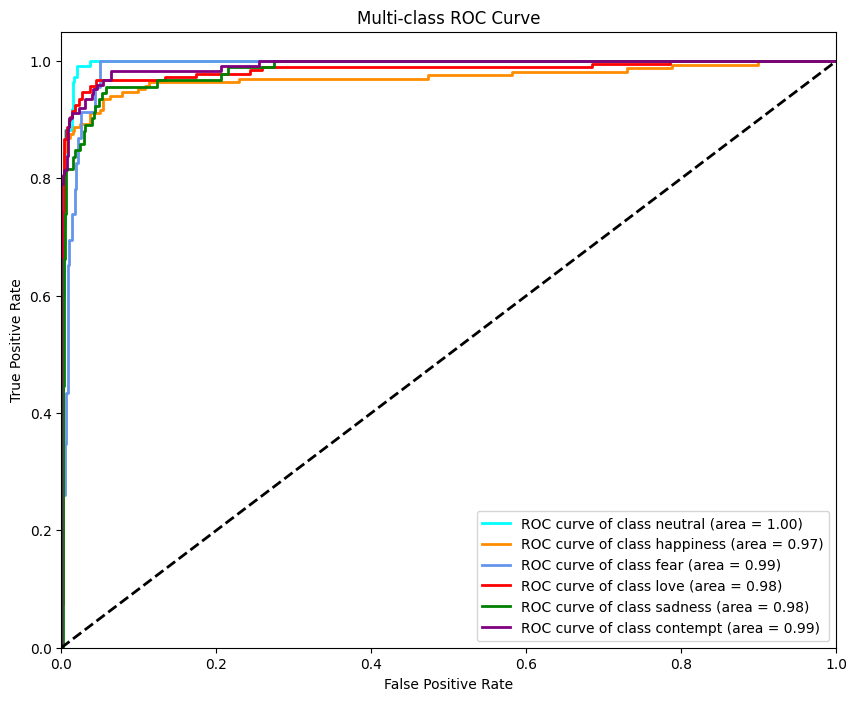

Saved classifier model as large_classifier_cls.pt


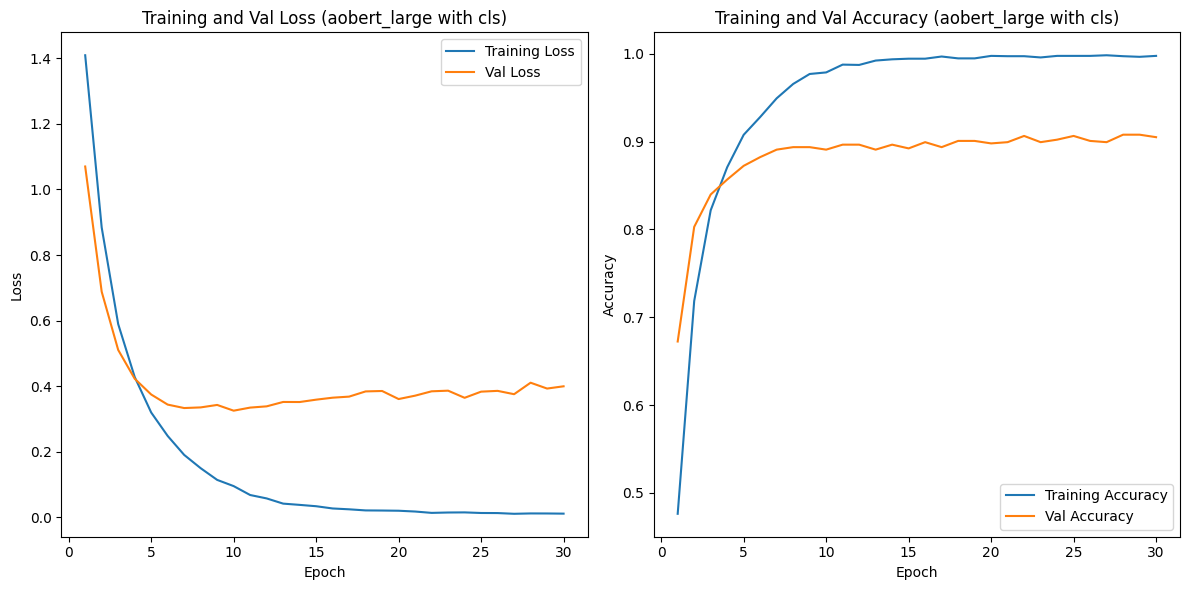

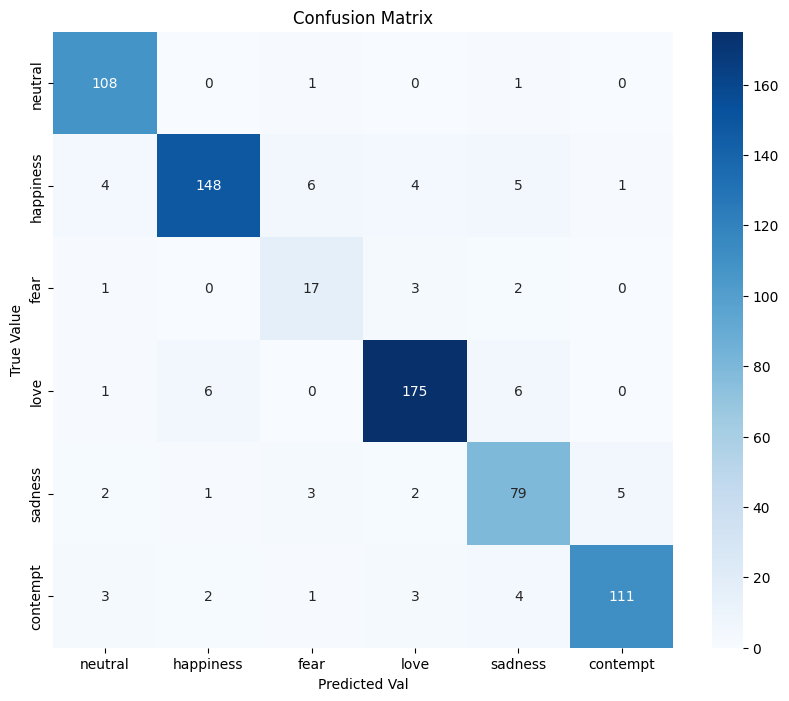


AOBERT-large with cls Summary:

╒═════════════════════════╤═════════════════════════════════╤═══════════╤═══════════════╤═════════╕
│ Layer (Type)            │ Output Shape                    │   Param # │   Trainable # │   Depth │
╞═════════════════════════╪═════════════════════════════════╪═══════════╪═══════════════╪═════════╡
│ Embedding               │ [1, 128, 512]                   │  25600000 │      25600000 │       2 │
├─────────────────────────┼─────────────────────────────────┼───────────┼───────────────┼─────────┤
│ Embedding               │ [1, 128, 512]                   │     65536 │         65536 │       2 │
├─────────────────────────┼─────────────────────────────────┼───────────┼───────────────┼─────────┤
│ MultiheadAttention      │ [[1, 128, 512], 'Not a Tensor'] │   1050624 │       1050624 │       5 │
├─────────────────────────┼─────────────────────────────────┼───────────┼───────────────┼─────────┤
│ Dropout                 │ [1, 128, 512]                   │      

In [ ]:
# ---------------------------
# 10. Main Execution Flow
# ---------------------------
if __name__ == "__main__":
    # Configuration
    MODEL_TYPE = "large"  # small/base/large
    DL_TYPE = "cls"    # None/lstm/bilstm/cnn
    PRETRAINED_PATH = f"/content/drive/MyDrive/AOBERT/Models_Pretrained/aobert_{MODEL_TYPE}_pretrained.pt"
    CLASSIFIER_PATH = f"/content/drive/MyDrive/AOBERT/Models_Classifiers/{MODEL_TYPE}_classifier_{DL_TYPE}.pt" if DL_TYPE else f"/content/drive/MyDrive/AOBERT/Models_Classifiers/{MODEL_TYPE}_classifier.pt"

    # Build vocabulary
    token2id, id2token = build_vocab('/content/drive/MyDrive/AOBERT/Data_Cleaned/afaanoromoo_pretrain_corpus.txt')

    # Initialize models
    if not os.path.exists(PRETRAINED_PATH):
        print("Starting pretraining...")
        train_dataset = MLMDataset('/content/drive/MyDrive/AOBERT/Data_Cleaned/afaanoromoo_pretrain_corpus.txt', token2id)
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
        model = globals()[f"create_aobert{MODEL_TYPE}"](len(token2id))
        pretrain(model, train_loader, f"aobert_{MODEL_TYPE}", epochs=10)
    else:
        print("Loading pretrained model...")
        model = globals()[f"create_aobert{MODEL_TYPE}"](len(token2id))
        model.load_state_dict(torch.load(PRETRAINED_PATH, map_location=torch.device('cpu')))

    # Initialize classifier
    label_mapping = {
        0: "neutral",
        1: "happiness",
        2: "fear",
        3: "love",
        4: "sadness",
        5: "contempt"
    }
    classifier = Classifier(model, num_classes=6, dl_model_type=DL_TYPE)
    # Prepare dataset
    class_dataset = ClassificationDataset('/content/drive/MyDrive/AOBERT_MODEL/Datasets-Cleaned/preprocessed_ao_emotional_corpus_no_sw_1.csv', token2id)
    train_size = int(0.8 * len(class_dataset))
    test_size = len(class_dataset) - train_size
    train_cls, test_cls = torch.utils.data.random_split(class_dataset, [train_size, test_size])
    train_loader = DataLoader(train_cls, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_cls, batch_size=64)

    # Train classifier
    train_classifier(classifier, train_loader, test_loader, epochs=30,
                    label_mapping=label_mapping, model_type=MODEL_TYPE,
                    dl_model_type=DL_TYPE)

    # Print model summary
    print_model_summary(classifier, input_size=(1, 128), vocab_size=len(token2id),
                       model_type=f"AOBERT-{MODEL_TYPE} with {DL_TYPE if DL_TYPE else 'CLS'}",
                       max_depth=6)


In [ ]:
print("\nInteractive testing mode:")
while True:
    text = input("\nEnter text for classification (or 'exit'): ")
    if text.lower() == 'exit':
        break
    predict_class(text, classifier, token2id, label_mapping)


Interactive testing mode:

Enter text for classification (or 'exit'): Goota akkasii dhabuun nama gaddisiisa
Predicted class: sadness

Enter text for classification (or 'exit'): Amma deemuu dandeenya
Predicted class: neutral

Enter text for classification (or 'exit'): yeroo kanatti si argachuu kootti gammachuu guddaatu natti dhagahama
Predicted class: happiness

Enter text for classification (or 'exit'): exit
